In [12]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import os
import glob
import xarray as xr
from sklearn import preprocessing
import netCDF4 as nc
import matplotlib.pyplot as plt


np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

BASE = '/scratch/ab10313/pleiades/'
PATH_NN_surface = BASE+'NN_data_surface/'
PATH_NN_interior = BASE+'NN_data_interior/'

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataloader

### Create input and output channels

In [14]:
# load preprocessed data into input and output channels



# X INPUT
grad_B = np.load(PATH_NN+'grad_B.npy')
FCOR = np.load(PATH_NN+'FCOR.npy')
Nsquared = np.load(PATH_NN+'Nsquared.npy')
HML = np.load(PATH_NN+'HML.npy')
TAU = np.load(PATH_NN+'TAU.npy')
Q = np.load(PATH_NN+'Q.npy')
HBL = np.load(PATH_NN+'HBL.npy')
div = np.load(PATH_NN+'div.npy')
vort = np.load(PATH_NN+'vort.npy')
strain = np.load(PATH_NN+'strain.npy')

X_input = np.stack([FCOR, grad_B, HML, Nsquared, TAU, Q, HBL, div, vort, strain],axis=1)
print('X input shape:')
print( X_input.shape)
print('')


# Y OUTPUT
WB_sg = np.load(PATH_NN+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN+'WB_sg_std.npy')
              
Y_output = np.tile(WB_sg,(1,1,1,1)).reshape(WB_sg.shape[0],1,WB_sg.shape[1],WB_sg.shape[2]) 
print('Y output shape:')
print(Y_output.shape)
print('')

np.isnan(X_input).any()
np.isnan(Y_output).any()

X input shape:
(8450, 10, 40, 40)

Y output shape:
(8450, 1, 40, 40)



False

In [15]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [16]:
PATH_LIST_full

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [17]:
label_list = ['Bengal','Agulhas', 'New Zealand', 'North Pacific', 'Equatorial Atlantic',
              'Gulf', 'South Atlantic', 'Argentina', 'Australia', 'Indian Ocean']

In [18]:
#season indecies
JAS_ind_min = 577
JAS_ind_max = 762

JFM_ind_min = 213
JFM_ind_max = 396

#locations
location_index = np.zeros(X_input.shape[0])
JFM_index = np.empty(X_input.shape[0])
JFM_index[:] = np.nan
JAS_index = np.empty(X_input.shape[0])
JAS_index[:] = np.nan


for i in range(10):
    for j in range(845):
        location_index[i*845+j] = i

        if JAS_ind_min<j & j<JAS_ind_max:
            JAS_index[i*845+j] = i*845+j
            
        elif JFM_ind_min<j & j<JFM_ind_max:
            JFM_index[i*845+j] = i*845+j
        

### randomly generate train, test and validation sets

In [19]:
# TRAIN AND TEST ONLY
# randomnly generate train, test and validation time indecies 
import random

print(f"Dataset: train: no location i, test: location i")
loc_num = 5

time_ind = np.arange(X_input.shape[0])
train_ind = time_ind[location_index!=loc_num]
test_ind = time_ind[location_index==loc_num]
rand_seed = 14
random.Random(rand_seed).shuffle(train_ind)

# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')
    

Dataset: train: no location i, test: location i
no overlapping indecies


### defined train, test and val dataloaders

In [20]:
# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch


###### training dataset #######
torch_dataset_train = Data.TensorDataset(
    torch.from_numpy(X_input[train_ind]).double(),
    torch.from_numpy(Y_output[train_ind]).double(),
)

loader_train = Data.DataLoader(
    dataset=torch_dataset_train, batch_size=BATCH_SIZE, shuffle=True
)
print('TRAIN')
print('X input shape:')
print( X_input[train_ind].shape)
print('Y output shape:')
print( Y_output[train_ind].shape)
print('')

###### test dataset #######
torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_input[test_ind]).double(),
    torch.from_numpy(Y_output[test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST')
print('X input shape:')
print( X_input[test_ind].shape)
print('Y output shape:')
print( Y_output[test_ind].shape)
print('')


###### test JFM dataset #######

JFM_test_ind = JFM_index[test_ind]
JFM_test_ind = JFM_test_ind[~np.isnan(JFM_test_ind)]
JFM_test_ind = np.int_(JFM_test_ind)


torch_dataset_test_JFM = Data.TensorDataset(
    torch.from_numpy(X_input[JFM_test_ind]).double(),
    torch.from_numpy(Y_output[JFM_test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test_JFM)

loader_test_JFM = Data.DataLoader(
    dataset=torch_dataset_test_JFM, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST_JFM')
print('X input shape:')
print( X_input[JFM_test_ind].shape)
print('Y output shape:')
print( Y_output[JFM_test_ind].shape)
print('')


###### test JAS dataset #######

JAS_test_ind = JAS_index[test_ind]
JAS_test_ind = JAS_test_ind[~np.isnan(JAS_test_ind)]
JAS_test_ind = np.int_(JAS_test_ind)


torch_dataset_test_JAS = Data.TensorDataset(
    torch.from_numpy(X_input[JAS_test_ind]).double(),
    torch.from_numpy(Y_output[JAS_test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test_JAS)

loader_test_JAS = Data.DataLoader(
    dataset=torch_dataset_test_JAS, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST_JAS')
print('X input shape:')
print( X_input[JAS_test_ind].shape)
print('Y output shape:')
print( Y_output[JAS_test_ind].shape)
print('')



TRAIN
X input shape:
(7605, 10, 40, 40)
Y output shape:
(7605, 1, 40, 40)

TEST
X input shape:
(845, 10, 40, 40)
Y output shape:
(845, 1, 40, 40)

TEST_JFM
X input shape:
(182, 10, 40, 40)
Y output shape:
(182, 1, 40, 40)

TEST_JAS
X input shape:
(184, 10, 40, 40)
Y output shape:
(184, 1, 40, 40)



## CNN - direct fluxes 3 output channels

In [21]:
# define network structure in pytorch
import torch.nn.functional as FF

class CNN_direct(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(10, 128, 5, padding='same', padding_mode='reflect')  # 7 inputs, 128 neurons for first hidden layer
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding='same', padding_mode='reflect')  # 128 inputs, 64 neurons for first hidden layer
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 48, 5, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv3_bn=nn.BatchNorm2d(48)  
        self.conv4 = nn.Conv2d(48, 32, 5, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv4_bn=nn.BatchNorm2d(32) 
        self.conv5 = nn.Conv2d(32, 16, 5, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv5_bn=nn.BatchNorm2d(16)  
        self.conv6 = nn.Conv2d(16, 8, 5, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv6_bn=nn.BatchNorm2d(8) 
        self.conv7 = nn.Conv2d(8, 1, 5, padding='same', padding_mode='reflect')  # 16 inputs, 1 neurons for first hidden layer
        self.conv7_bn=nn.BatchNorm2d(1) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x))
        x = self.conv6(x)
        x = F.relu(self.conv6_bn(x))
        x = self.conv7(x)
        x = self.conv7_bn(x)
        return x
 
    


## Train and test model: direct fluxes

In [22]:
# train network 
def train_model_direct(net, criterion, trainloader, optimizer, len_train_dataset, text="train"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(trainloader)}")
    
    net.train()
    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
        nb = b_y.shape[0]
        train_loss = train_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    train_loss /= len_train_dataset  # dividing by the number of batches
    print(text + " loss:", train_loss)
    return train_loss


def test_model_direct(net, criterion, testloader, optimizer,len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len_test_dataset  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss



def plot_model_direct(net, criterion, testloader, len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    #with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(
        testloader
    ):  # for each training step
        b_x = Variable(batch_x, requires_grad=True)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        nb = b_y.shape[0]
        test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    test_loss /= len_test_dataset  # dividing by the number of batches
    #         print(len(trainloader))
    print(text + " loss:", test_loss)
    return b_x, b_y, prediction


criterion = torch.nn.MSELoss()  # MSE loss function




## load CNN!

In [23]:
cnn_submeso = torch.load(PATH_NN_surface+'cnn_7l_k5_surface_inputs_'+label_list[loc_num]+'_test.pth')


In [24]:
total_params = sum(
	param.numel() for param in cnn_submeso.parameters()
)
total_params


346691

In [25]:
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test,len(torch_dataset_test))

Training starts on device Quadro RTX 8000, number of samples 1


RuntimeError: Given groups=1, weight of size [128, 3, 5, 5], expected input[845, 10, 44, 44] to have 3 channels, but got 10 channels instead

# locations

In [ ]:
location_test = location_index[test_ind]

# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[test_ind]
WB_sg_std_test = WB_sg_std[test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn = np.squeeze((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg = np.squeeze(xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,845,40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,845*40*40))

WB_sg_loc = np.empty((10,845,40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,845*40*40))

for i_loc in range(10):
    WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    
    WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()


# Regional statistics

## positive fluxes

In [ ]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0



WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
WB_cnn.name = 'WB_cnn'
WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
WB_sg.name = 'WB_sg'

xhist_CNN = xhist(WB_cnn, 
  WB_sg,
  bins=[np.logspace(-10,-6,30), 
        np.concatenate((-np.logspace(-6,-10,30),
                        np.concatenate((np.linspace(-9e-11,9e-11,5),
                                        np.logspace(-10,-6,30)))))
       ]
 ).compute()


ax = plt.subplot(5,2,i_loc+1)
xhist_CNN.plot(vmax=800, cmap='Blues')
ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([0,1e-6])
ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
ax.set_ylabel(r"$CNN$", 
              fontsize=13)
plt.title(label_list[i_loc])


plt.savefig('./figures/cnn_7l_k5_surface_inputs_Gulf_test_positive_fluxes')

## negative fluxes

In [ ]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=200, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc])


plt.savefig('./figures/cnn_7l_k5_surface_inputs_Gulf_test_negative_fluxes')

# Seasonality - JFM


In [ ]:
# build test loader for JFM and JAS
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test_JFM,len(torch_dataset_test_JFM))

In [26]:
location_test = location_index[JFM_test_ind]

# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[JFM_test_ind]
WB_sg_std_test = WB_sg_std[JFM_test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn = np.squeeze((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg = np.squeeze(xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,len(JFM_test_ind),40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,len(JFM_test_ind)*40*40))

WB_sg_loc = np.empty((10,len(JFM_test_ind),40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,len(JFM_test_ind)*40*40))

for i_loc in range(10):
    WB_cnn_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = WB_cnn[location_index[JFM_test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    
    WB_sg_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = WB_sg[location_index[JFM_test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()


NameError: name 'b_x' is not defined

## positive fluxes

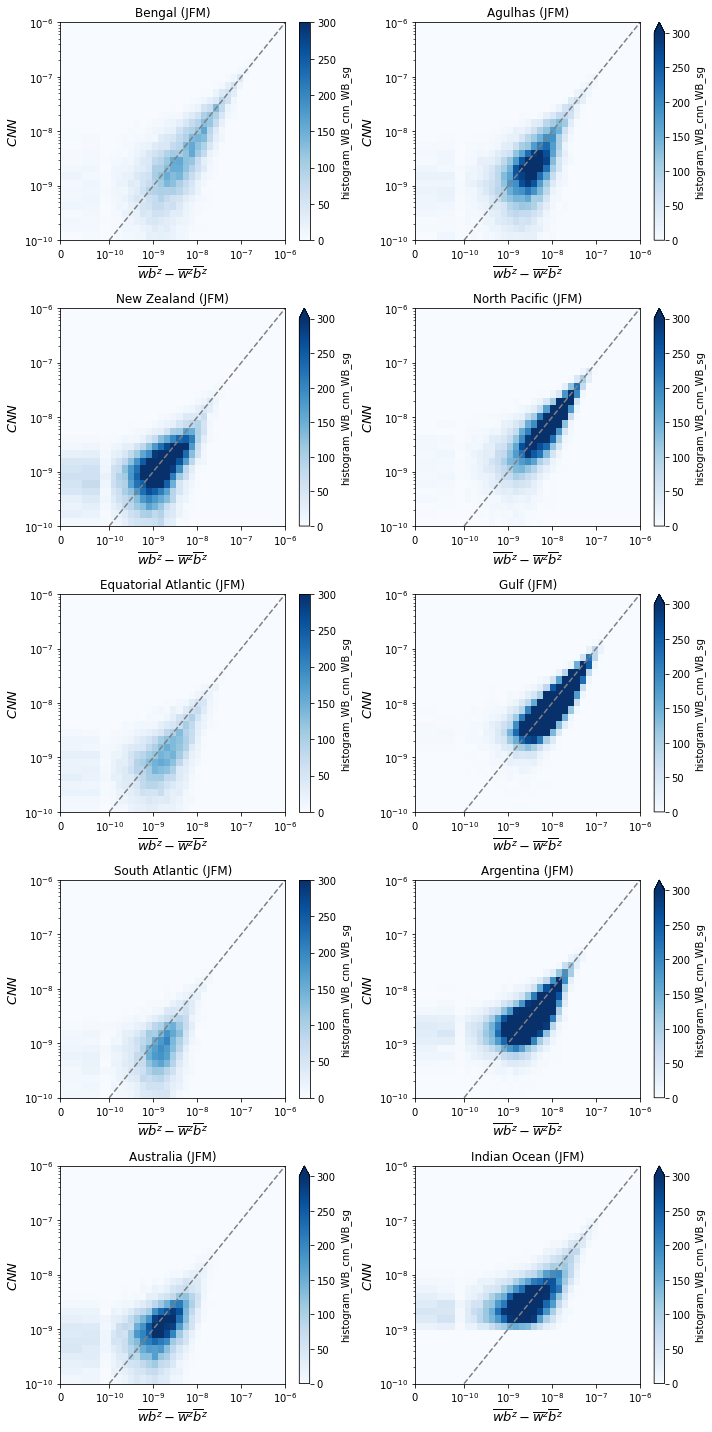

In [20]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=300, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JFM)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_Gulf_test_positive_fluxes_seasonality_JFM')

## negative fluxes

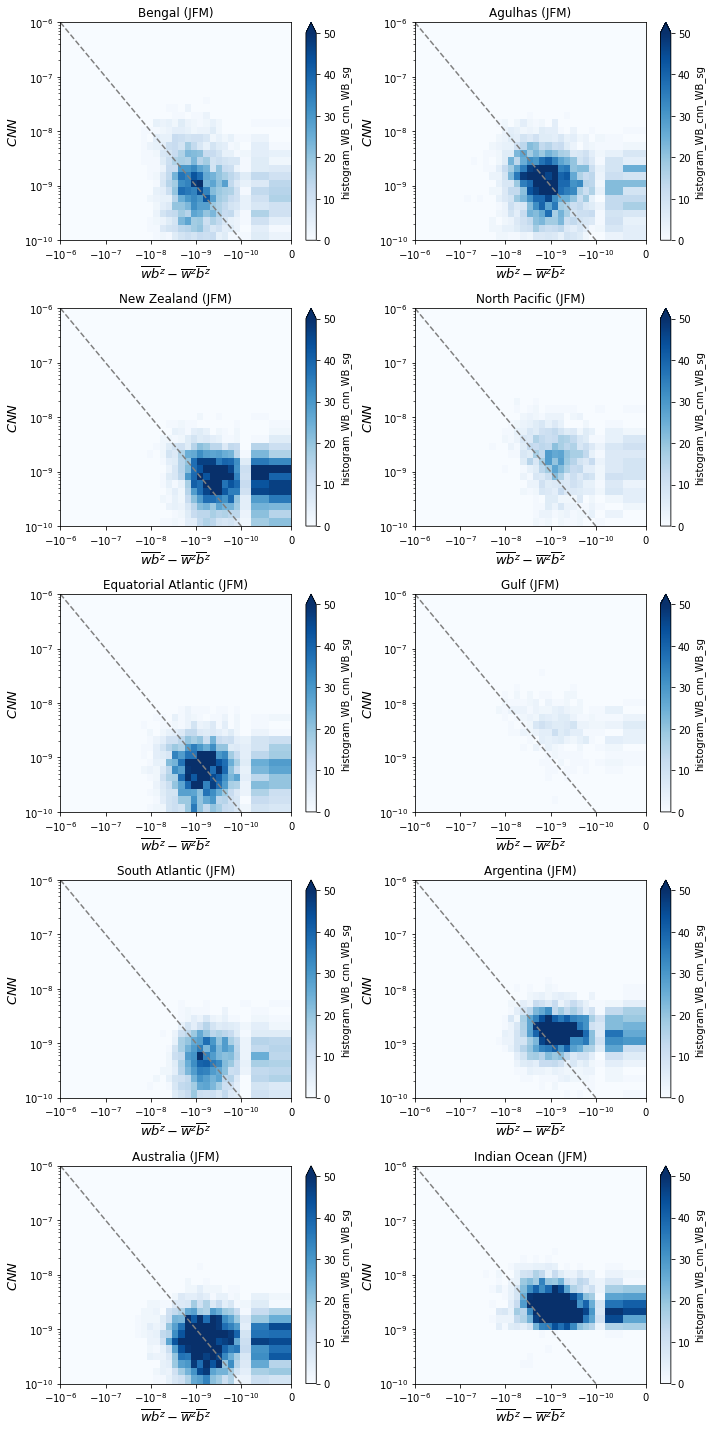

In [21]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=50, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JFM)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_Gulf_test_negative_fluxes_seasonality_JFM')

# Seasonality - JAS


In [22]:
# build test loader for JFM and JAS
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test_JAS,len(torch_dataset_test_JAS))

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.3301627888695176


In [23]:
location_test = location_index[JAS_test_ind]

# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[JAS_test_ind]
WB_sg_std_test = WB_sg_std[JAS_test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn = np.squeeze((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg = np.squeeze(xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,len(JAS_test_ind),40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,len(JAS_test_ind)*40*40))

WB_sg_loc = np.empty((10,len(JAS_test_ind),40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,len(JAS_test_ind)*40*40))

for i_loc in range(10):
    WB_cnn_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = WB_cnn[location_index[JAS_test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    
    WB_sg_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = WB_sg[location_index[JAS_test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()


## positive fluxes

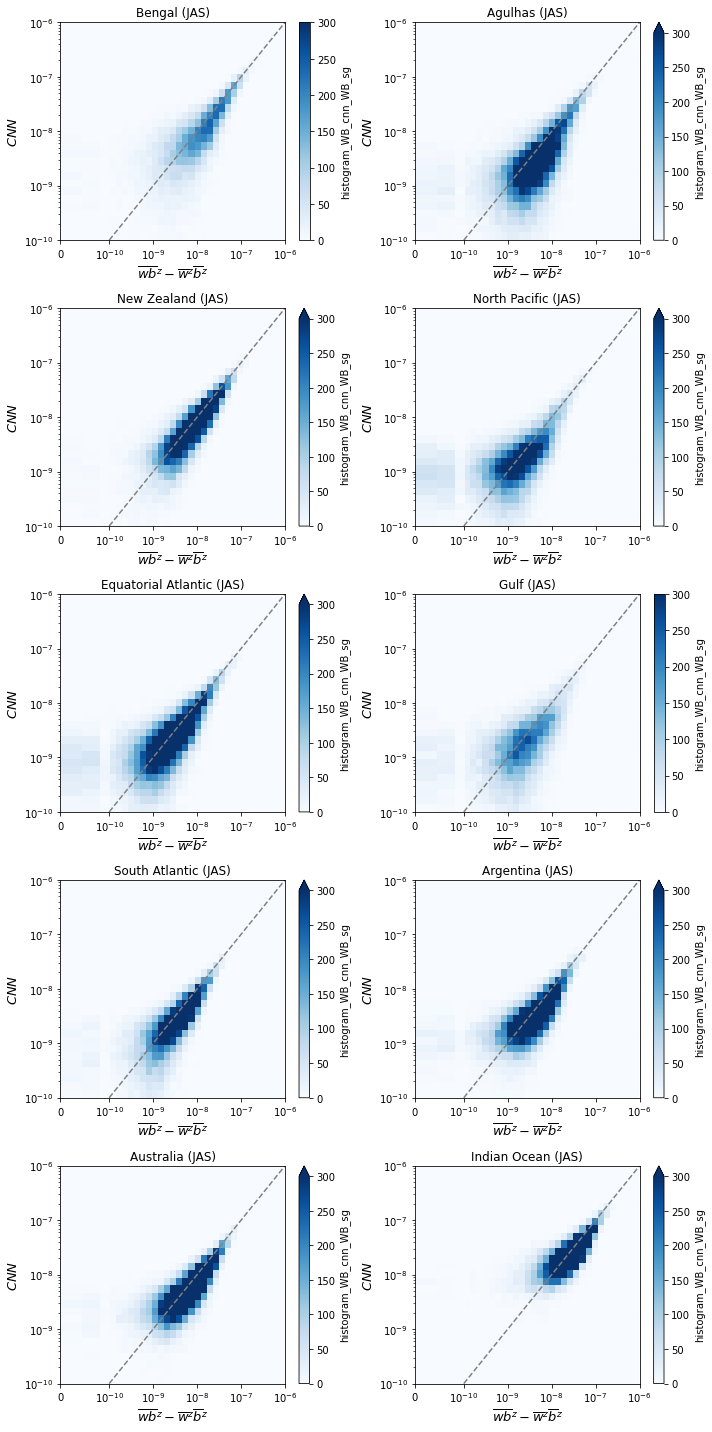

In [24]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    
    
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=300, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JAS)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_Gulf_test_negative_fluxes_seasonality_JAS')

## negative fluxes

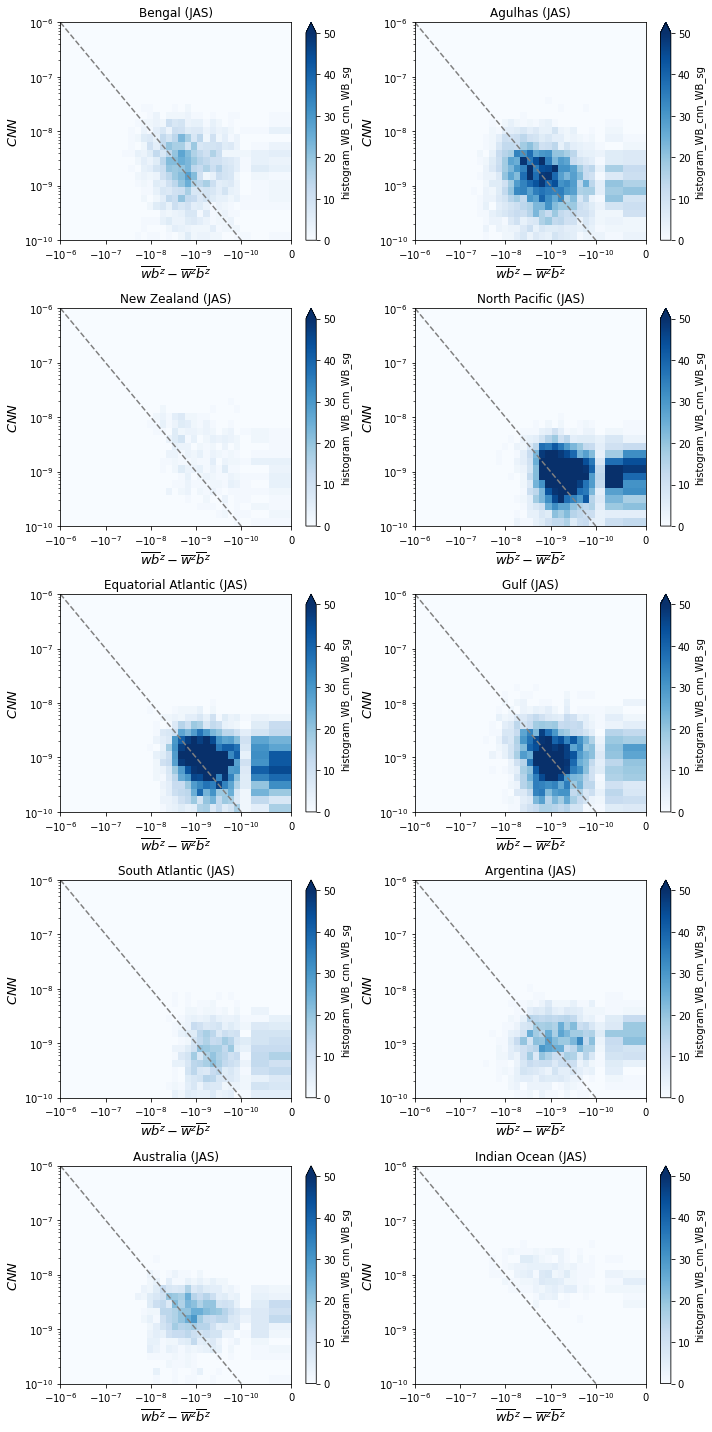

In [25]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=50, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JAS)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_Gulf_test_negative_fluxes_seasonality_JAS')